# Homework 5

In [1]:
from astropy.io import ascii
from astropy.table import Column
import os
import numpy as np
from matplotlib import pyplot
%matplotlib inline

In [2]:
data_dir = '../data/'

## Problem 1

Read in data

In [3]:
tbdata = ascii.read(os.path.join(data_dir, 'lx_t.dat'), 
                    names = ['luminosity', 'temperature', 'error'])
x = np.log10(tbdata['luminosity'])
y = np.log10(tbdata['temperature'])
error = np.sqrt(((1./(tbdata['temperature']*np.log(10)))*tbdata['error'])**2)

### Part a

Calculate alpha

In [4]:
f = [1., x]
alpha = np.matrix(np.empty((2,2)))
alpha[0,0] = np.sum((1./error**2)*f[0]*f[0])
alpha[0,1] = np.sum((1./error**2)*f[0]*f[1])
alpha[1,0] = np.sum((1./error**2)*f[1]*f[0])
alpha[1,1] = np.sum((1./error**2)*f[1]*f[1])
print('alpha = \n', alpha)

('alpha = \n', matrix([[  1.54135531e+06,   6.86711369e+07],
        [  6.86711369e+07,   3.06058359e+09]]))


Calculate beta

In [5]:
beta = np.matrix(np.empty((2, 1)))
beta[0] = np.sum((y*f[0])/(error**2))
beta[1] = np.sum((y*f[1])/(error**2))
print('beta = \n', beta)

('beta = \n', matrix([[   869914.47997512],
        [ 39055278.28353415]]))


Invert alpha

In [6]:
alpha_inv = np.linalg.inv(alpha)

Calc best fit parameters

In [7]:
a = alpha_inv*beta
print('intercept = ', a[0])
print('slope = ', a[1])

('intercept = ', matrix([[-11.34006114]]))
('slope = ', matrix([[ 0.26720073]]))


In [8]:
#Check answer
np.polyfit(x, y, 1, w = 1./error)

array([  0.26720073, -11.34006114])

### Part b

In [9]:
ymod = np.polyval(np.array([a[1], a[0]]), x)
chi_sq = np.sum(((y - ymod)/(error))**2)
print('chi square = ', chi_sq)

('chi square = ', 18464.181156302249)


In [10]:
#DOF = num pts - num params - my notes say this but online says num pts - num params - 1
reduced_chi = chi_sq/(len(tbdata) - 2.)
print('reduced chi square', reduced_chi)

('reduced chi square', 68.133509801853322)


This is not a good fit b/c the reduced chi-square >> 1

### Part c

In [11]:
def calc_lin_best_fit_params(x, y, error):
    f = [1., x]
    alpha = np.matrix(np.empty((2,2)))
    alpha[0,0] = np.sum((1./error**2)*f[0]*f[0])
    alpha[0,1] = np.sum((1./error**2)*f[0]*f[1])
    alpha[1,0] = np.sum((1./error**2)*f[1]*f[0])
    alpha[1,1] = np.sum((1./error**2)*f[1]*f[1])
    beta = np.matrix(np.empty((2, 1)))
    beta[0] = np.sum((y*f[0])/(error**2))
    beta[1] = np.sum((y*f[1])/(error**2))
    alpha_inv = np.linalg.inv(alpha)
    a = alpha_inv*beta
    return a

In [12]:
x = np.log10(tbdata['luminosity'])
y = np.log10(tbdata['temperature'])
error = np.sqrt(((1./(tbdata['temperature']*np.log(10)))*tbdata['error'])**2)

a0 = []
a1 = []
for interation in range(100000):
    #Select N data points with replacement
    indx = np.random.uniform(0, len(tbdata), size = len(tbdata))
    indx = np.int_(indx)
    #Calculate best fit parameters
    a = calc_lin_best_fit_params(x[indx], y[indx], error[indx])
    a0.append(a[0])
    a1.append(a[1])
a0 = np.array(a0)
a1 = np.array(a1)
error_a0 = a0.std()
error_a1 = a1.std()
print('1 sig error in zeropoint = {:.2f}'.format(error_a0))
print('1 sig error in slope = {:.2f}'.format(error_a1))

1 sig error in zeropoint = 0.71
1 sig error in slope = 0.02


### Part D

In [13]:
x = np.log10(tbdata['luminosity'])
y = np.log10(tbdata['temperature'])
error = np.sqrt(((1./(tbdata['temperature']*np.log(10)))*tbdata['error'])**2)
npts = len(tbdata)

a = calc_lin_best_fit_params(x, y, error)

a0_partial = []
a1_partial = []
for j in range(npts):
    mask = np.bool_(np.ones(npts,))
    mask[j] = False
    #Calculate best fit parameters
    aj = calc_lin_best_fit_params(x[mask], y[mask], error[mask])
    a0_partial.append(aj[0])
    a1_partial.append(aj[1])
a0_partial = np.array(a0_partial)
a1_partial = np.array(a1_partial)
a0_psuedo = npts*a[0,0].flatten() - (npts - 1.)*a0_partial
a1_psuedo = npts*a[1,0].flatten() - (npts - 1.)*a1_partial

a0_jackknife = 1./npts * a0_psuedo.sum()
a1_jackknife = 1./npts * a1_psuedo.sum()

print('jackknife estimate of intercept = {:.2f}'.format(a0_jackknife))
print('jackknife estimate of slope = {:.2f}'.format(a1_jackknife))

jackknife estimate of intercept = -11.37
jackknife estimate of slope = 0.27


# Problem 2

In [14]:
a0 =  -27.61096136  #intercept
a1 =  0.37077094 #slope
sigma_a0 = 1.44424598843
sigma_a1 = 0.0258325312691

a0_terms = np.linspace(a0-4*sigma_a0, a0+4*sigma_a0, 100.)
a1_terms = np.linspace(a1-4*sigma_a1, a1+4*sigma_a1, 99)
grid = np.empty((100, 99, 2))
for i, ia0 in enumerate(a0_terms):
    for j, ia1 in enumerate(a1_terms):
        grid[i,j, 0] = ia0
        grid[i, j, 1] = ia1
        
#Alternately if the note on meshgrid had been in the preamble to the problem
xx, yy = np.meshgrid(a0_terms, a1_terms)

Read in the data 

In [15]:
tbdata = ascii.read(os.path.join(data_dir, 'xy_fitting.txt'), names = ['x', 'y'])
y_err = np.ones(len(tbdata))*5
tbdata.add_column(Column(y_err, name = 'sigma'))

## Part a

Calculate chi square

In [16]:
#I couldn't figure out how to do this without a loop but I'm sure there's a way
#Given more time I would at least loop over the data rather than the grid and then sum for the chi-square
chi_sq = np.empty(grid[:,:,0].shape)
for i in range(100):
    for j in range(99):
        ymod = grid[i, j, 0] + grid[i, j, 1]*tbdata['x']
        chi_sq[i,j] = (((tbdata['y'] - ymod)/tbdata['sigma'])**2).sum()

Calculate $\Delta\chi^{2}$ using value from last week

In [17]:
hw4_chi_sq = 55.7842090928
delta_chi_sq = chi_sq - hw4_chi_sq

Make contour plot

/Users/abostroem/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/abostroem/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


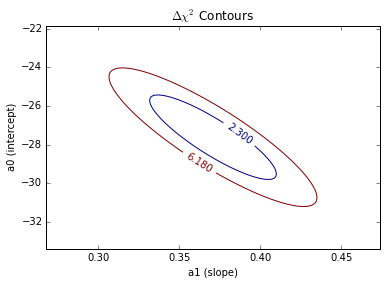

In [18]:
c = pyplot.contour(a1_terms, a0_terms, delta_chi_sq, [2.3, 6.18])
pyplot.clabel(c)
pyplot.xlabel('a1 (slope)')
pyplot.ylabel('a0 (intercept)')
pyplot.title('$\Delta\chi^{2}$ Contours')

The contours of constant $\Delta\chi^{2}$ can be interpreted as confidence limits. 2.3 corresponds to 68% confidence given a function with 2 free parameters and 6.18 represents 95.4% confidence given a function with 2 free parameters


## Part b

priors:
* assume a0 is uniformly distributed between [a0-4$\sigma$, a0+4$\sigma$]
* assume a1 is uniformly distributed between [a1-4$\sigma$, a1+4$\sigma$]
* assume a gaussian distribution for errors

In [19]:
def calc_posterior_probability(tbdata, ia0, ia1):
    #Create the model
    ymod = ia0+ia1*tbdata['x']
    #Calculate the likelihood
    likelihood = np.product(1./(np.sqrt(2.*np.pi)*tbdata['sigma']) * \
                            np.exp(-(tbdata['y'] - ymod)**2/(2.*(tbdata['sigma'])**2)))
    #calculate the pixel size (d_a0*d_a1) or probability of model assuming a uniform distribution
    d_a0 = (a0_terms[-1]-a0_terms[0])/a0_terms.size
    d_a1 = (a1_terms[-1] - a1_terms[0])/a1_terms.size
    #Calculate the posterior probability
    posterior_prob = likelihood*d_a0*d_a1
    return posterior_prob

Calculate the posterior (unnormalized) for each point in model

In [20]:
posterior = np.empty(grid[:,:,0].shape)
for i in range(100):
    for j in range(99):
        posterior[i,j]= calc_posterior_probability(tbdata, grid[i, j, 0], grid[i, j, 1])

Normalize the posterior to a posterior probability by summing the P(data|model) over all models

In [21]:
prob_data = np.sum(posterior.flatten())
posterior_prob = posterior/prob_data

Determine the probabilities corresponding to 68% confidence and 95.4% confidence. Note this has to be done with a CDF and can't simple be calculated as a percent of points

In [22]:
sorted_posterior_prob = np.sort(posterior_prob.flatten())
cdf_grid = np.cumsum(sorted_posterior_prob)
one_sig = sorted_posterior_prob[cdf_grid < 0.32][-1]
two_sig = sorted_posterior_prob[cdf_grid < 0.046][-1]
print('68% confidence = {}'.format(one_sig))
print('95.4% confidence = {}'.format(two_sig))

68% confidence = 0.000678467300487
95.4% confidence = 9.70515218196e-05


Make a contour plot of these confidence limits

<a list of 2 text.Text objects>

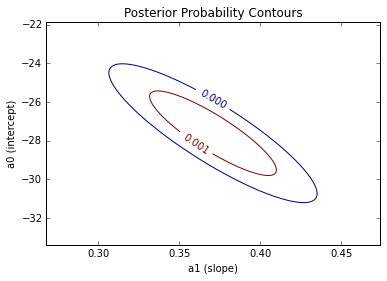

In [23]:
c = pyplot.contour(a1_terms, a0_terms, posterior_prob, [one_sig, two_sig])
pyplot.xlabel('a1 (slope)')
pyplot.ylabel('a0 (intercept)')
pyplot.title('Posterior Probability Contours')
pyplot.clabel(c)

This plot looks pretty similar to the one in part a

# Problem 3

## Part a

Find the projection of $\Delta\chi^{2}$ onto a0

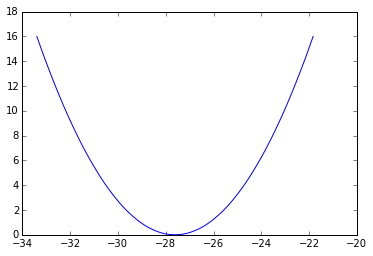

In [24]:
#Find the best fit a1
min_delta_chi_sq_a0 = delta_chi_sq.min(axis = 1)
pyplot.plot(a0_terms, min_delta_chi_sq_a0)

Evaluate confidence limits for $\Delta\chi^{2} \le 1 $ for a0 (intercept)

In [25]:
chi_sq_less_than_1_a0 = min_delta_chi_sq_a0 <= 1
print('confidence limits for a0 = [{:.2f}, {:.2f}]'.format(a0_terms[chi_sq_less_than_1_a0][0], 
                                                           a0_terms[chi_sq_less_than_1_a0][-1]))
print('a0 = {:.3f} +/- {:.3f}'.format(a0_terms[np.argmin(min_delta_chi_sq_a0)], 
                                              (a0_terms[chi_sq_less_than_1_a0][-1] - a0_terms[chi_sq_less_than_1_a0][0])/2))

print('from linear fit last week: a0 = {:.3f} +/- {:.3f}'.format(-27.61096136, 1.44424598843))

confidence limits for a0 = [-28.95, -26.27]
a0 = -27.553 +/- 1.342
from linear fit last week: a0 = -27.611 +/- 1.444


Find the projection of $\Delta\chi^{2}$ onto a1

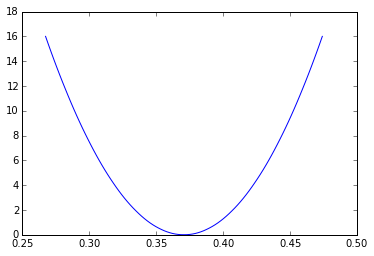

In [26]:
#Find the best fit a0
min_delta_chi_sq_a1 = delta_chi_sq.min(axis = 0)
pyplot.plot(a1_terms, min_delta_chi_sq_a1)

Find confidence limits corresponding to $\Delta\chi^{2} \le 1 $ for a1 (slope)

In [27]:
chi_sq_less_than_1_a1 = min_delta_chi_sq_a1 <= 1
print('confidence limits for a1 = [{:.2f}, {:.2f}]'.format(a1_terms[chi_sq_less_than_1_a1][0], 
                                                           a1_terms[chi_sq_less_than_1_a1][-1]))

print('a1 = {:.3f} +/- {:.3f}'.format(a1_terms[np.argmin(min_delta_chi_sq_a1)], 
                                              (a1_terms[chi_sq_less_than_1_a1][-1] - a1_terms[chi_sq_less_than_1_a1][0])/2))
print('From linear fit last week: a1 = {:.3f} +/- {:.3f}'.format(0.37077094, 0.0258325312691))

confidence limits for a1 = [0.35, 0.40]
a1 = 0.371 +/- 0.025
From linear fit last week: a1 = 0.371 +/- 0.026


The value is a little different for intercept and the error is less for the delta chi square method than the linear fit method. The value and error are very close for the slope parameter.

## Part b

Find the marginalized probability for a0 and plot it

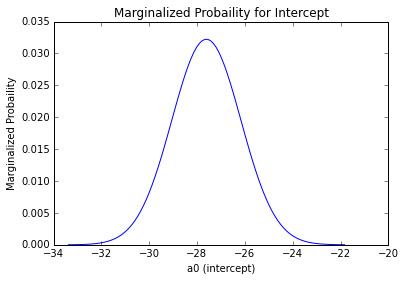

In [28]:
marginal_a0 = np.sum(posterior_prob, axis = 1)
pyplot.plot(a0_terms, marginal_a0)
pyplot.xlabel('a0 (intercept)')
pyplot.ylabel('Marginalized Probaility')
pyplot.title('Marginalized Probaility for Intercept')

Find the marginalized probability for a1 and plot it

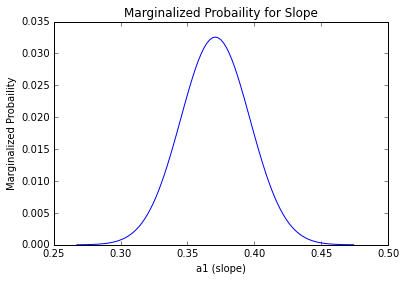

In [29]:
marginal_a1 = np.sum(posterior_prob, axis = 0)
pyplot.plot(a1_terms, marginal_a1)
pyplot.xlabel('a1 (slope)')
pyplot.ylabel('Marginalized Probaility')
pyplot.title('Marginalized Probaility for Slope')

Determine the 68% confidence regions

In [30]:
cdf_a0 = np.cumsum(marginal_a0)
#Assumes a symmetric PDF
one_sig_a0 = a0_terms[np.argmax(marginal_a0)] - a0_terms[np.array(cdf_a0)<0.16][-1]

print('a0 = {:.3f} +/- {:.3f}'.format(a0_terms[np.argmax(marginal_a0)],one_sig_a0))

a0 = -27.669 +/- 1.517


In [31]:
cdf_a1 = np.cumsum(marginal_a1)
#Assumes a symmetric PDF
one_sig_a1 = a1_terms[np.argmax(marginal_a1)] - a1_terms[np.array(cdf_a1)<0.16][-1]

print('a1 = {:.3f} +/- {:.3f}'.format(a1_terms[np.argmax(marginal_a1)],one_sig_a1))

a1 = 0.371 +/- 0.027
